# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [1]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка

*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выделите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
X, y = df.drop(['salary_in_usd', 'salary'], axis=1), df['salary_in_usd']

display(X.sample(10))
display(y.sample(10))

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
3158,2022,MI,FT,AI Scientist,USD,US,0,US,M
1281,2023,EN,FT,Data Analyst,USD,US,50,US,M
2342,2022,SE,FT,Data Scientist,USD,US,100,US,M
2310,2022,SE,FT,Data Engineer,USD,US,0,US,M
772,2023,SE,FT,Data Engineer,GBP,GB,0,GB,M
2212,2022,SE,FT,Data Scientist,USD,US,0,US,M
2933,2022,MI,CT,Analytics Engineer,USD,BO,50,BO,M
1143,2023,SE,FT,Data Engineer,USD,US,0,US,M
122,2023,SE,FT,Machine Learning Engineer,USD,US,100,US,M
2886,2022,SE,FT,Data Scientist,USD,US,100,US,M


3684     88654
2008    153000
2946    160000
3526    144000
570     105500
1646    114000
3108    109280
1129    200000
2042    120000
1526    135000
Name: salary_in_usd, dtype: int64

Столбец `salary` $-$ это, очевидно, зарплата работника в исходной валюте, поэтому по идее он должен отличаться от `salary_in_usd` только на курс доллара США к валюте, в которой зарплата выдаётся. Так что для предотвращения обучения модели курсам валют `salary_currency` вообще удалим колонку `salary`.

In [4]:
# Чтобы val и test были одинакового размера, используем абсолютное число строк в качестве test_size
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = len(X) // 10, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = len(X) // 10, random_state = 42)

X_train.shape, X_test.shape, X_val.shape

((3005, 9), (375, 9), (375, 9))

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from time import perf_counter
from timeit import timeit

In [6]:
categorical_features = X.columns[X.dtypes == 'object'].to_list()
categorical_features

['experience_level',
 'employment_type',
 'job_title',
 'salary_currency',
 'employee_residence',
 'company_location',
 'company_size']

In [7]:
def ohe_transform(encoder: OneHotEncoder, data: pd.DataFrame) -> pd.DataFrame:
    return pd.concat(
        [
            data.drop(columns=categorical_features),
            pd.DataFrame(
                encoder.transform(data[categorical_features]), # type: ignore
                columns=encoder.get_feature_names_out(categorical_features),
                index=data.index,
            ),
        ],
        axis=1,
    )

In [8]:
ohe = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore',
    feature_name_combiner=lambda x, y: str(x).replace(' ', '_') + '_' + str(y).replace(' ', '_'),
).fit(
    X_train_full[categorical_features],
)

X_train_full_ohe = ohe_transform(ohe, X_train_full)
X_train_ohe = ohe_transform(ohe, X_train)
X_val_ohe = ohe_transform(ohe, X_val)
X_test_ohe = ohe_transform(ohe, X_test)

In [9]:
models = []
loss_values = [[], []]
times = [[], []]
best_params = [{}]

In [10]:
linreg = LinearRegression()

start_time = perf_counter()
linreg.fit(X_train_full_ohe, y_train_full)
end_time = perf_counter()

times[0].append(end_time - start_time)

y_pred = linreg.predict(X_test_ohe)

mape = mean_absolute_percentage_error(y_test, y_pred)
loss_values[0].append(mape)

rmse = root_mean_squared_error(y_test, y_pred)
loss_values[1].append(rmse)

models.append('LinearRegression')

print(f"LinearRegression MAPE: {mape:.3f}")
print(f"LinearRegression RMSE: {rmse:.3f}")

LinearRegression MAPE: 0.437
LinearRegression RMSE: 51044.650


In [11]:
stmt_code = "model.predict(X_test)"

total_time = timeit(
    stmt=stmt_code,
    setup="from __main__ import linreg as model, X_test_ohe as X_test",
    number=1000,
)

times[1].append(total_time)

## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [12]:
from xgboost import XGBRegressor

In [13]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [14]:
base_xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'booster': 'gbtree',
    'random_state': 42,
}

In [15]:
def objective(trial: optuna.Trial) -> float:
    xgb_params = {
        'n_jobs': 1,
        'early_stopping_rounds': 50,

        'n_estimators': trial.suggest_int('n_estimators', 25, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),

        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
    }

    if trial.suggest_categorical('use_min_child_weight', [True, False]):
        xgb_params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 20)

    if trial.suggest_categorical('use_subsample', [True, False]):
        xgb_params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)

    if trial.suggest_categorical('use_colsample_bytree', [True, False]):
        xgb_params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    if trial.suggest_categorical('use_reg_alpha', [True, False]):
        xgb_params['reg_alpha'] = trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True)

    if trial.suggest_categorical('use_reg_lambda', [True, False]):
        xgb_params['reg_lambda'] = trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)

    y_pred = XGBRegressor(**base_xgb_params, **xgb_params).fit(
        X_train_ohe, y_train,
        eval_set=[(X_val_ohe, y_val)],
        verbose=False,
    ).predict(X_val_ohe)

    return root_mean_squared_error(y_val, y_pred)

In [16]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
)

study.optimize(objective, n_trials=1000, n_jobs=-1)

In [17]:
def extract_params(param_dict: dict) -> dict:
    return {
        param: value

        for param, value in param_dict.items()

        if not param.startswith('use_') and (
            f'use_{param}' not in param_dict.keys() or param_dict[f'use_{param}']
        )
    }

In [18]:
best_params.append(extract_params(study.best_params))

for param, value in best_params[-1].items():
    print(f"Best {param} = {value}")

Best n_estimators = 82
Best learning_rate = 0.22532268848101383
Best max_depth = 8
Best gamma = 2.702603261066582
Best subsample = 0.5789198851919923
Best reg_alpha = 0.016242558188449864


In [19]:
xgb = XGBRegressor(**base_xgb_params, **best_params[-1])

start = perf_counter()
xgb.fit(X_train_full_ohe, y_train_full)
end = perf_counter()

times[0].append(end - start)

y_pred = xgb.predict(X_test_ohe)

mape = mean_absolute_percentage_error(y_test, y_pred)
loss_values[0].append(mape)

rmse = root_mean_squared_error(y_test, y_pred)
loss_values[1].append(rmse)

models.append('XGBRegressor')

print(f"XGBRegressor MAPE: {mape:.3f}")
print(f"XGBRegressor RMSE: {rmse:.3f}")

XGBRegressor MAPE: 0.409
XGBRegressor RMSE: 50765.164


In [20]:
total_time = timeit(
    stmt=stmt_code,
    setup="from __main__ import xgb as model, X_test_ohe as X_test",
    number=1000,
)

times[1].append(total_time)

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [21]:
from catboost import CatBoostRegressor, Pool

In [22]:
from warnings import filterwarnings
filterwarnings("ignore", category=UserWarning)

In [23]:
base_cb_params = {
    'bootstrap_type': 'MVS',
    'loss_function': 'RMSE',
    'verbose': 0,
    'random_seed': 42,
}

In [24]:
def objective(trial: optuna.Trial) -> float:
    cb_params = {
        'eval_metric': 'RMSE',
        'iterations': trial.suggest_int('iterations', 25, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
    }

    if trial.suggest_categorical('use_min_data_in_leaf', [True, False]):
        cb_params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 1, 20)

    if trial.suggest_categorical('use_l2_leaf_reg', [True, False]):
        cb_params['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True)

    if trial.suggest_categorical('use_rsm', [True, False]):
        cb_params['rsm'] = trial.suggest_float('rsm', 0.6, 1.0)

    if trial.suggest_categorical('use_random_strength', [True, False]):
        cb_params['random_strength'] = trial.suggest_float('random_strength', 1e-8, 10.0, log=True)

    y_pred = CatBoostRegressor(**base_cb_params, **cb_params).fit(
        X_train_ohe, y_train,
        eval_set=(X_val_ohe, y_val),
        early_stopping_rounds=50,
        verbose=0,
    ).predict(X_val_ohe)

    return root_mean_squared_error(y_val, y_pred)

In [25]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
)

study.optimize(objective, n_trials=1000, n_jobs=-1)

In [26]:
best_params.append(extract_params(study.best_params))

for param, value in best_params[-1].items():
    print(f"Best {param} = {value}")

Best iterations = 139
Best learning_rate = 0.17552811123039766
Best depth = 10
Best rsm = 0.7118071251349088
Best random_strength = 0.00013387830508942723


In [27]:
cb = CatBoostRegressor(**base_cb_params, **best_params[-1])

start = perf_counter()
cb.fit(X_train_full_ohe, y_train_full, verbose=0)
end = perf_counter()

times[0].append(end - start)

y_pred = cb.predict(X_test_ohe)

mape = mean_absolute_percentage_error(y_test, y_pred)
loss_values[0].append(mape)

rmse = root_mean_squared_error(y_test, y_pred)
loss_values[1].append(rmse)

models.append('CatBoostRegressor')

print(f"CatBoostRegressor MAPE: {mape:.3f}")
print(f"CatBoostRegressor RMSE: {rmse:.3f}")

CatBoostRegressor MAPE: 0.405
CatBoostRegressor RMSE: 49337.590


In [28]:
total_time = timeit(
    stmt=stmt_code,
    setup="from __main__ import cb as model, X_test_ohe as X_test",
    number=1000,
)

times[1].append(total_time)

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [29]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_features,
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=categorical_features,
)

In [30]:
base_cb_params = {
    'bootstrap_type': 'MVS',
    'loss_function': 'RMSE',
    'verbose': 0,
    'random_seed': 42,
}

In [31]:
def objective(trial: optuna.Trial) -> float:
    cb_params = {
        'eval_metric': 'RMSE',
        'iterations': trial.suggest_int('iterations', 25, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
    }

    if trial.suggest_categorical('use_min_data_in_leaf', [True, False]):
        cb_params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 1, 20)

    if trial.suggest_categorical('use_l2_leaf_reg', [True, False]):
        cb_params['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True)

    if trial.suggest_categorical('use_rsm', [True, False]):
        cb_params['rsm'] = trial.suggest_float('rsm', 0.6, 1.0)

    if trial.suggest_categorical('use_random_strength', [True, False]):
        cb_params['random_strength'] = trial.suggest_float('random_strength', 1e-8, 10.0, log=True)

    if trial.suggest_categorical('use_one_hot_max_size', [True, False]):
        cb_params['one_hot_max_size'] = trial.suggest_int('one_hot_max_size', 2, 25)

    y_pred = CatBoostRegressor(**base_cb_params, **cb_params).fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=50,
        verbose=0,
    ).predict(val_pool)

    return root_mean_squared_error(y_val, y_pred)

In [32]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
)

study.optimize(objective, n_trials=1000, n_jobs=-1)

In [33]:
best_params.append(extract_params(study.best_params))

for param, value in best_params[-1].items():
    print(f"Best {param} = {value}")

Best iterations = 91
Best learning_rate = 0.24564123864408594
Best depth = 9
Best min_data_in_leaf = 16
Best rsm = 0.8270352874335707
Best random_strength = 1.0371923233211262e-08
Best one_hot_max_size = 25


In [34]:
full_train_pool = Pool(
    data=X_train_full,
    label=y_train_full,
    cat_features=categorical_features,
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=categorical_features,
)

In [35]:
cb = CatBoostRegressor(**base_cb_params, **best_params[-1])

start = perf_counter()
cb.fit(full_train_pool, verbose=0)
end = perf_counter()

times[0].append(end - start)

y_pred = cb.predict(test_pool)

mape = mean_absolute_percentage_error(y_test, y_pred)
loss_values[0].append(mape)

rmse = root_mean_squared_error(y_test, y_pred)
loss_values[1].append(rmse)

models.append('CatBoostRegressor (with Pool)')

print(f"CatBoostRegressor (with Pool) MAPE: {mape:.3f}")
print(f"CatBoostRegressor (with Pool) RMSE: {rmse:.3f}")

CatBoostRegressor (with Pool) MAPE: 0.429
CatBoostRegressor (with Pool) RMSE: 51181.373


In [36]:
total_time = timeit(
    stmt=stmt_code,
    setup="from __main__ import cb as model, test_pool as X_test",
    number=1000,
)

times[1].append(total_time)

**Ответ:** стало хуже... Причём и по качеству, и по скорости... Видимо, дополнительная обработка категориальных признаков в CatBoost как минимум замедляет обучение, а как максимум мешает оптимальному нахождению предикатов в деревьях.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [37]:
from lightgbm import LGBMRegressor

In [38]:
base_lgbm_params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'random_state': 42,
    'verbose': -1,
}

In [39]:
def objective(trial: optuna.Trial) -> float:
    lgbm_params = {
        'n_jobs': 1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 25, 200),
    }

    if trial.suggest_categorical('use_subsample', [True, False]):
        lgbm_params['subsample'] = trial.suggest_float('subsample', 0.6, 1.0, step=0.1)

    if trial.suggest_categorical('use_colsample_bytree', [True, False]):
        lgbm_params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1)

    if trial.suggest_categorical('use_reg_alpha', [True, False]):
        lgbm_params['reg_alpha'] = trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)

    if trial.suggest_categorical('use_reg_lambda', [True, False]):
        lgbm_params['reg_lambda'] = trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)

    if trial.suggest_categorical('use_min_child_samples', [True, False]):
        lgbm_params['min_child_samples'] = trial.suggest_int('min_child_samples', 5, 100)

    y_pred = LGBMRegressor(**base_lgbm_params, **lgbm_params).fit(
        X_train_ohe, y_train,
        eval_set=[(X_val_ohe, y_val)],
    ).predict(X_val_ohe)

    return root_mean_squared_error(y_val, y_pred)

In [40]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
)

study.optimize(objective, n_trials=1000, n_jobs=-1)

In [41]:
best_params.append(extract_params(study.best_params))

for param, value in best_params[-1].items():
    print(f"Best {param} = {value}")

Best num_leaves = 90
Best learning_rate = 0.0246859676894971
Best n_estimators = 106
Best subsample = 0.8
Best colsample_bytree = 0.7
Best reg_alpha = 2.315442099385427e-06
Best min_child_samples = 36


In [42]:
lgbm = LGBMRegressor(**base_lgbm_params, **best_params[-1])

start = perf_counter()
lgbm.fit(X_train_full_ohe, y_train_full)
end = perf_counter()

times[0].append(end - start)

y_pred = lgbm.predict(X_test_ohe)

mape = mean_absolute_percentage_error(y_test, y_pred)
loss_values[0].append(mape)

rmse = root_mean_squared_error(y_test, y_pred)
loss_values[1].append(rmse)

models.append('LGBMRegressor')

print(f"LGBMRegressor MAPE: {mape:.3f}")
print(f"LGBMRegressor RMSE: {rmse:.3f}")

LGBMRegressor MAPE: 0.402
LGBMRegressor RMSE: 51967.966


In [43]:
total_time = timeit(
    stmt=stmt_code,
    setup="from __main__ import lgbm as model, X_test_ohe as X_test",
    number=1000,
)

times[1].append(total_time)

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

In [44]:
display(pd.DataFrame(loss_values, columns=models, index=['MAPE', 'RMSE']).transpose())
display(pd.DataFrame(times, columns=models, index=['Train Time (seconds)', 'Inference Time (milliseconds)']).transpose())
display(pd.DataFrame(best_params, index=models))

,MAPE,RMSE
LinearRegression,0.436643,51044.649957
XGBRegressor,0.408834,50765.164062
CatBoostRegressor,0.404546,49337.589594
CatBoostRegressor (with Pool),0.428917,51181.372521
LGBMRegressor,0.402186,51967.966428


,Train Time (seconds),Inference Time (milliseconds)
LinearRegression,0.046505,0.781454
XGBRegressor,0.102921,4.396622
CatBoostRegressor,0.622375,2.088538
CatBoostRegressor (with Pool),2.044369,0.438695
LGBMRegressor,1.414604,1.174796


,n_estimators,learning_rate,max_depth,gamma,subsample,reg_alpha,iterations,depth,rsm,random_strength,min_data_in_leaf,one_hot_max_size,num_leaves,colsample_bytree,min_child_samples
LinearRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBRegressor,82.0,0.225323,8.0,2.702603,0.57892,0.016243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CatBoostRegressor,NaN,0.175528,NaN,NaN,NaN,NaN,139.0,10.0,0.711807,1.338783e-04,NaN,NaN,NaN,NaN,NaN
CatBoostRegressor (with Pool),NaN,0.245641,NaN,NaN,NaN,NaN,91.0,9.0,0.827035,1.037192e-08,16.0,25.0,NaN,NaN,NaN
LGBMRegressor,106.0,0.024686,NaN,NaN,0.80000,0.000002,NaN,NaN,NaN,NaN,NaN,NaN,90.0,0.7,36.0


**Ответ:**

Все модели градиентного бустинга, очевидно, показали лучший результат, чем обычная линейная регрессия (по метрике `MAPE`), поскольку учитывают нелинейные связи в данных.

Наименьший `RMSE` у обычного `CatBoostRegressor` без использования `Pool` для выделения категориальных признаков, а наименьший `MAPE` у `LGBMRegressor`.

По времени обучения выигрывает `XGBRegressor`, видимо из-за большого количества листьев преимущество `leaf-wise` построения деревьев в `LGBMRegressor` не раскрылось на данном датасете. Тем не менее по времени предсказания лучший результат у `CatBoostRegressor` с использованием `Pool` (даже быстрее обычной линейной регрессии `LinearRegression`!), всё-таки оптимизация `Pool` в `CatBoost` действительно сильно ускоряет прохождение по листам деревьев.

При этом `CatBoostRegressor` с `Pool` оказался наиболее медленным по скорости обучения, поскольку строятся симметричные деревья фиксированной глубины, а для категориальных признаков требуется дополнительная обработка.

По скорости предсказания проиграл `XGBRegressor`, но поскольку время запуска всё равно исчисляется миллисекундами, это совсем не критично.

По поводу гиперпараметров: в `XGBRegressor` кроме базовых `n_estimators`, `learning_rate` и `max_depth` можно настроить `gamma` и `reg_alpha` (отвечают за регуляризацию) и `subsample` (определяет долю строк-объектов для обучения каждого дерева).

У `CatBoostRegressor` базовые гиперпараметры $-$ это `iterations`, `learning_rate` и `depth`. При этом для предотвращения переобучения симметричных деревьев можно использовать `rsm` (доля признаков, используемых для обучения каждого из деревьев) и `random_strength` ("сила" случайной перестановки). При использовании `Pool` также оказалось полезным ограничить число объектов в листах с помощью `min_data_in_leaf` и установить `one_hot_max_size` (максимальное число категорий, которые могут быть закодированы `OneHotEncoder`).

У `LGBMRegressor` кроме базовых гиперпараметров `n_estimators`, `learning_rate` и `num_leaves` полезно настроить регуляризацию: `reg_alpha` (коэффициент регуляризации), `subsample` и `colsample_bytree` (доли датасета, используемые для обучения каждого из деревьев) и `min_child_samples` (ограничивает число объектов в листовых вершинах $-$ предотвращает ненужные сплиты).

Судя по документациям `XGBoost`, `CatBoost` и `LightGBM`, у `XGBRegressor`, `CatBoostRegressor` и `LGBMRegressor` есть множество других гиперпараметров, но часть из них синонимична используемым (например, `learning_rate` и `eta` в `CatBoost`), а другие оказались ненужными для повышения качества предсказаний на валидационной выборке (подбор проводился с использованием библиотеки `optuna` и `TPESampler`, поскольку полный `grid search` слишком затратен при таком количестве гиперпараметров, а `random search` не дал хорошего качества при разумном `n_iter`).

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [45]:
ratings = pd.read_excel("sample_matrix.xlsx", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [46]:
ratings = ratings.transpose()

Выкиньте строку под названием `user`.

In [47]:
ratings = ratings.drop(['user'])

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [48]:
ratings.fillna(0, inplace=True)
ratings.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the bee gees,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r. kelly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gnarls barkley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
journey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
morricone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [49]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5, random_state=42).fit(ratings)
labels = pd.Series(km.labels_)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [50]:
labels.value_counts()

3    882
0    115
4      1
2      1
1      1
Name: count, dtype: int64

**Ответ:** Получился один большой кластер и $4$ маленьких $-$ вряд ли это соответствует действительности. Тем более что $3$ кластера вообще состоят из одного исполнителя, при таком количестве данных ($1000$ исполнителей, $5000$ пользователей) явно можно найти кластеризацию, при которой эти исполнители будут объединены в группу с какими-то другими, а их выделение поодиночке не имеет смысла.

Судя по всему, три исполнителя, для которых `KMeans` сделал отдельные кластеры, чем-то очень сильно выделяются среди $1000$ представленных в датасете исполнителей. Исходя из сути таблицы (доли прослушиваний), у них может быть либо супер мало прослушиваний (что маловероятно), либо супер много (скорее всего это очень популярные группы, которых слушает большинство пользователей). 

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [51]:
import numpy as np

In [52]:
pred = km.predict(ratings)

for cluster_num in np.unique(labels):
    artists = ratings[pred == cluster_num].index.to_list()

    print(f"\nCluster #{cluster_num} -> {len(artists)} artists")

    if len(artists) <= 10:
        print("\t", end="")
        print(*artists, sep="\n\t")


Cluster #0 -> 115 artists

Cluster #1 -> 1 artists
	日dir en grey

Cluster #2 -> 1 artists
	niИ

Cluster #3 -> 882 artists

Cluster #4 -> 1 artists
	the beatles


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [53]:
ratings['Active Rate'] = ratings.apply(lambda artist: (artist > 0).sum() / len(artist), axis=1)
ratings['Average Listen Rate'] = ratings.apply(lambda artist: artist.mean(), axis=1)
ratings['Average Active Listen Rate'] = ratings.apply(lambda artist: artist[artist > 0].mean(), axis=1)

ratings[['Active Rate', 'Average Listen Rate', 'Average Active Listen Rate']].describe()

,Active Rate,Average Listen Rate,Average Active Listen Rate
count,1000.000000,1000.000000,1000.000000
mean,0.026826,0.000998,0.037692
std,0.025980,0.001050,0.012726
min,0.009400,0.000182,0.017100
25%,0.012200,0.000457,0.029566
50%,0.017600,0.000690,0.035107
75%,0.031250,0.001151,0.041931
max,0.334200,0.018432,0.159558


In [54]:
print(ratings.iloc[ratings['Active Rate'].argmax()].name)
print(ratings.iloc[ratings['Average Listen Rate'].argmax()].name)
print(ratings.iloc[ratings['Average Active Listen Rate'].argmax()].name)

the beatles
the beatles
日dir en grey


In [55]:
display(ratings['Active Rate'].sort_values(ascending=False).head(3))
display(ratings['Average Listen Rate'].sort_values(ascending=False).head(3))
display(ratings['Average Active Listen Rate'].sort_values(ascending=False).head(3))

the beatles           0.3342
radiohead             0.2778
deathcab for cutie    0.1862
Name: Active Rate, dtype: float64

the beatles           0.018432
radiohead             0.011904
deathcab for cutie    0.006579
Name: Average Listen Rate, dtype: float64

日dir en grey       0.159558
보아                 0.146456
cannibal corpse    0.105091
Name: Average Active Listen Rate, dtype: float64

**Ответ:** Ну, `The Beatles` являются самой популярной группой в датасете по доле пользователей, которые их слушали хотя бы один раз. И лидерами по средней доле прослушивания среди всех исполнителей у активных слушателей. Так что при наивной кластеризации их можно выделить как единственную настолько популярную группу :)

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [56]:
from sklearn.preprocessing import normalize

ratings_norm = pd.DataFrame(normalize(ratings.iloc[:, :-3], axis=1), index=ratings.index)
ratings_norm

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
meshuggah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [57]:
km = KMeans(n_clusters=5, random_state=42).fit(ratings_norm)
labels = pd.Series(km.labels_, index=ratings_norm.index)

labels.value_counts()

4    486
1    162
3    140
2    133
0     79
Name: count, dtype: int64

**Ответ:** вот теперь есть $5$ кластеров с сопоставимыми размерами $-$ это имеет куда больше смысла, чем раньше. Возможно, даже получится определить "средний" жанр исполнителей внутри каждого из кластеров.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [58]:
from scipy.spatial.distance import cosine

centroids = km.cluster_centers_

for i, centroid in enumerate(centroids):
    cluster_artists = ratings_norm[labels == i]

    top = np.argsort(np.apply_along_axis(cosine, 1, cluster_artists, centroid))[:10]
    artists = cluster_artists.iloc[top].index

    print(f"TOP-{len(artists)} artists of cluster #{i + 1}:", end="\n\t")
    print(*artists, sep="\n\t")

TOP-10 artists of cluster #1:
	nas
	jay-z
	kanye west
	lupe the gorilla
	a tribe called quest
	the roots featuring d'angelo
	gangstarr
	little brother
	lil' wayne
	murs and 9th wonder
TOP-10 artists of cluster #2:
	fall out boy
	the all-americian rejects
	paramore
	kelly clarkson
	john mayer
	the fray
	maroon5
	dashboard confesssional
	somethings corporate
	coldplay
TOP-10 artists of cluster #3:
	brand new
	blink-182
	alkaline trio
	against me!
	underoath
	descendents
	new found glory
	less than jake
	thrice
	chiodos
TOP-10 artists of cluster #4:
	the beatles
	the rolling stones
	dylan. bob
	who
	led zeppelin.
	miles davis.
	simon and garfunkel
	young, neil
	pink fluid
	velvet underground
TOP-10 artists of cluster #5:
	radiohead
	the arcade fire
	the shins
	sufjan stevens
	belle and sebastian
	broken social scene
	the pixies
	animal collective
	modest mouse
	spoon


**Ответ:** В первом кластере, судя по всему, исполнители-рэперы. В остальных $-$ представители разных поджанров рока, причём из ТОП $10$ исполнителей кластера даже можно определить примерный стиль

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

In [59]:
import matplotlib.pyplot as plt

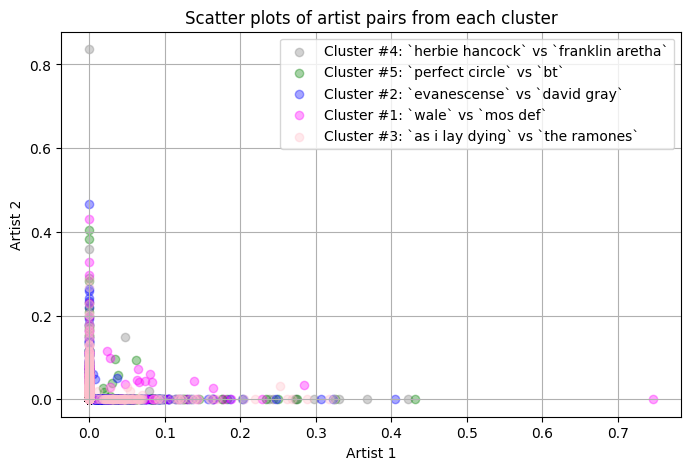

In [60]:
colors = ['red', 'green', 'blue', 'yellow', 'gray', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink', 'black']
colors = np.random.choice(colors, size=labels.nunique(), replace=False)

ax = plt.figure(figsize=(8, 5)).add_subplot(111)

for cluster in labels.unique():
    artists = ratings_norm[labels == cluster]
    artist1, artist2 = np.random.choice(artists.index, 2, replace=False)

    ax.scatter(
        ratings_norm.loc[artist1],
        ratings_norm.loc[artist2],
        color=colors[cluster],
        alpha=0.35,
        label=f"Cluster #{cluster + 1}: `{artist1}` vs `{artist2}`",
    )

ax.grid(True)

ax.set_xlabel("Artist 1")
ax.set_ylabel("Artist 2")

ax.set_title("Scatter plots of artist pairs from each cluster")
ax.legend()

plt.show();

**Ответ:** Выглядит странно. Очень много точек возле начала координат и вдоль осей $X$ и $Y$ (когда одно из значений равно $0$). При этом цвет кластера почти не влияет на расположение точки $-$ так что визуализация плохо интерпретируема. Надо строить другие графики $-$ данные в текущем виде имеют слишком высокую размерность

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

In [61]:
from sklearn.manifold import TSNE

two_dim = TSNE(random_state=42).fit_transform(ratings_norm)

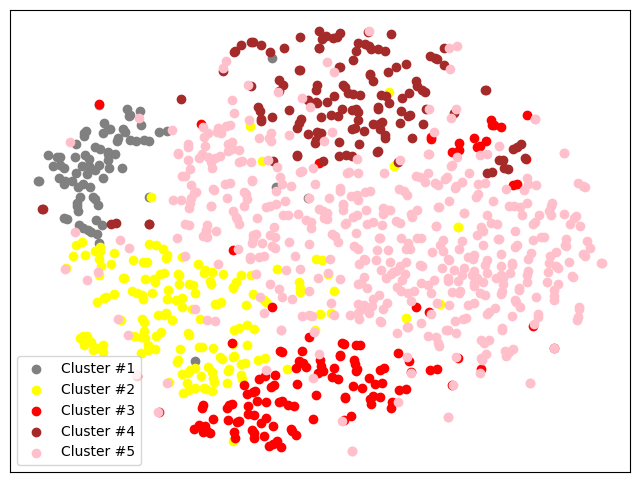

In [62]:
colors = ['red', 'green', 'blue', 'yellow', 'gray', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink', 'black']
colors = np.random.choice(colors, size=labels.nunique(), replace=False)

ax = plt.figure(figsize=(8, 6)).add_subplot(111)

for cluster in np.unique(labels):
    ax.scatter(two_dim[labels == cluster, 0], two_dim[labels == cluster, 1], color=colors[cluster], label=f"Cluster #{cluster + 1}")

ax.legend()
ax.set_xticks([])
ax.set_yticks([])

plt.show();

Теперь есть чёткое визуальное разделение на кластеры $-$ мало точек имеют цвет, отличный от своих соседей

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [63]:
from sklearn.metrics import silhouette_score

In [64]:
clusters = np.array(range(2, 101))
scores = np.array([
    silhouette_score(
        ratings_norm,
        KMeans(
            n_clusters=n,
            random_state=42,
        ).fit_predict(ratings_norm)
    )
    for n in clusters
])

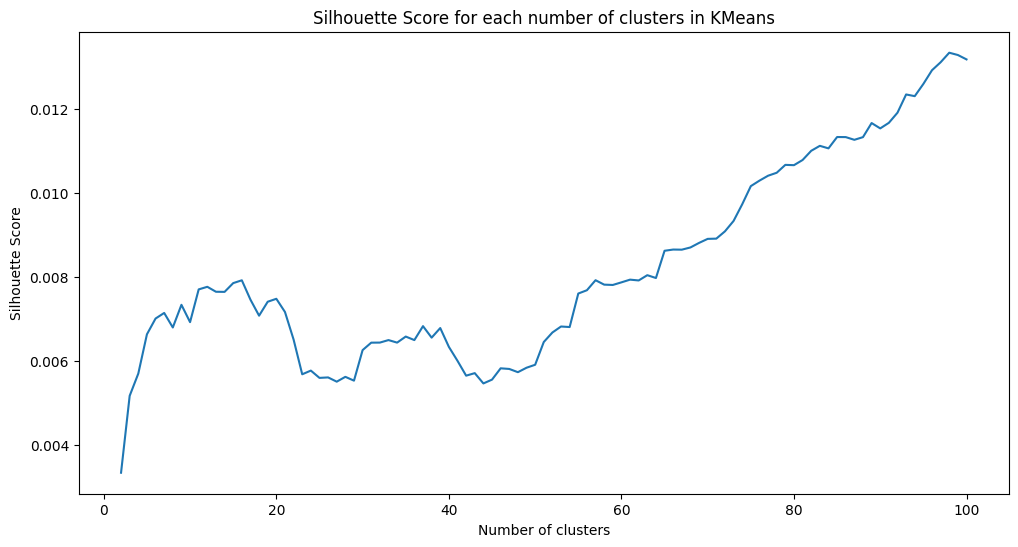

In [65]:
ax = plt.figure(figsize=(12, 6)).add_subplot(1, 1, 1)
ax.plot(clusters, scores)
ax.set_title('Silhouette Score for each number of clusters in KMeans')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')
plt.show();

In [66]:
best_n = clusters[scores.argmax()]

print(f"Best number of clusters = {best_n}")

km = KMeans(n_clusters=best_n, random_state=42).fit(ratings_norm)
labels = pd.Series(km.labels_, index=ratings_norm.index)

Best number of clusters = 98


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [67]:
centroids = km.cluster_centers_

for i, centroid in enumerate(centroids):
    cluster_artists = ratings_norm[labels == i]

    top = np.argsort(np.apply_along_axis(cosine, 1, cluster_artists, centroid))[:10]
    artists = cluster_artists.iloc[top].index

    print(f"TOP-{len(artists)} artists of cluster #{i + 1}:", end="\n\t")
    print(*artists, sep="\n\t")

TOP-6 artists of cluster #1:
	dr. dre
	the faint
	violent femmes
	margot and the nuclear so and sos
	owen
	the bloodhound gang
TOP-10 artists of cluster #2:
	john mayer
	matt nathanson
	gavin degraw
	jason mraz
	ray lamontagne
	joshua radin
	sara bareilles
	augustana
	maroon5
	o.a.r.
TOP-10 artists of cluster #3:
	white stripes
	beck
	the raconteurs
	spoon
	the pixies
	the strokes
	the flaming lips
	cake
	black rebel motorcycle club
	gorillaz
TOP-10 artists of cluster #4:
	fugazi
	jawbreaker
	sleater-kinney
	les savy fav
	capn jazz
	bad brains
	blonde redhead
	propagandhi
	the melvins
	gogol bordello
TOP-10 artists of cluster #5:
	ryan adams
	band of horses
	ryan adams and the cardinals
	rogue wave
	my morning jacket
	matt pond pa
	cloud cult
	the american analog set
	nada surf
	tv on the radio
TOP-10 artists of cluster #6:
	dj shadow
	rjd2
	amon tobin
	jedi mind tricks
	el-p
	aphex twin
	sublime
	moby*
	gnarls barkley
	soul coughing
TOP-10 artists of cluster #7:
	system of a down
	koЯ

**Ответ:** В целом смысл кластеров остался тот же $-$ группировка исполнителей, похожих по жанрам. Но засчёт бОльшего числа кластеров теперь можно про (почти) каждый кластер чётко сказать, к какому стилю и жанру относятся попавшие туда исполнители. Правда на самом деле есть по несколько кластеров с одними и теми же жанрами, но вообще исполнители могут менять стиль своей музыки со временем, так что их могут слушать пользователи, которым нравятся разные периоды их творчества, то есть при "усреднении" жанра исполнители могут попадать в схожие группы, хотя конкретные альбомы/песни по жанрам могут сильно различаться.

Интересный кластер номер $15$ $-$ туда попали Джон Леннон и Пол Маккартни, но не попали The Beatles :) А вот в тусовку рэперов в кластере номер $29$ затесался Элвис Пресли, причём с опечаткой...

Сделайте t-SNE визуализацию полученной кластеризации.

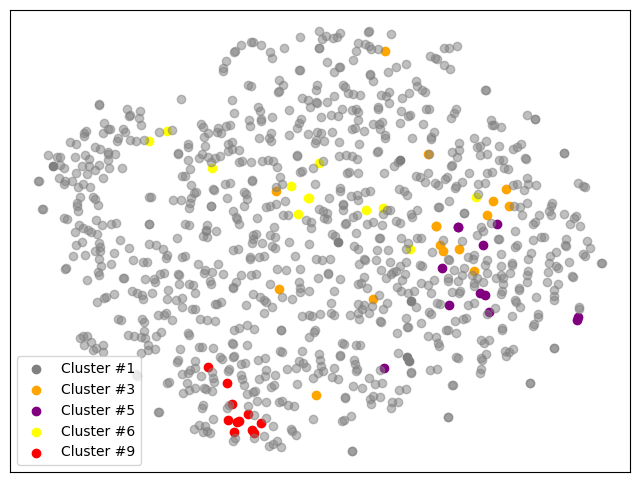

In [68]:
colors = ['red', 'green', 'blue', 'yellow', 'gray', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink']
colors = np.random.choice(colors, size=5, replace=False)

ax = plt.figure(figsize=(8, 6)).add_subplot(111)
colored = 0

for cluster in np.unique(labels):
    if colored < 5 and np.random.rand() < 0.5:
        ax.scatter(two_dim[labels == cluster, 0], two_dim[labels == cluster, 1], color=colors[colored], label=f"Cluster #{cluster + 1}")
        colored += 1
    else:
        ax.scatter(two_dim[labels == cluster, 0], two_dim[labels == cluster, 1], color='gray', alpha=0.5)

ax.legend()
ax.set_xticks([])
ax.set_yticks([])

plt.show();

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

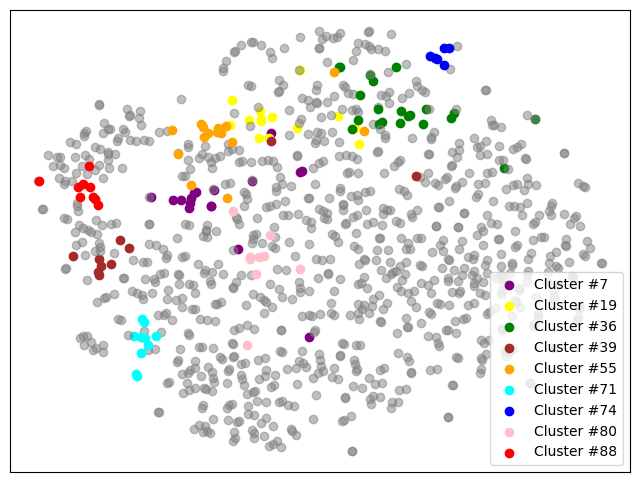

In [69]:
important_clusters = [7, 19, 36, 39, 55, 71, 74, 80, 88]

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink']
colors = np.random.choice(colors, size=len(important_clusters), replace=False)

ax = plt.figure(figsize=(8, 6)).add_subplot(111)

colors_iter = iter(colors)

for cluster in np.unique(labels):
    if cluster + 1 in important_clusters:
        ax.scatter(two_dim[labels == cluster, 0], two_dim[labels == cluster, 1], color=next(colors_iter), label=f"Cluster #{cluster + 1}")
    else:
        ax.scatter(two_dim[labels == cluster, 0], two_dim[labels == cluster, 1], color='gray', alpha=0.5)

ax.legend(loc='lower right')
ax.set_xticks([])
ax.set_yticks([])

plt.show();

**Ответ:** Интересное расположение и содержание кластера номер $74$ $-$ классические композиторы (Бах, Вивальди, Моцарт, ...). На визуализации видно, насколько обособленно расположен этот кластер относительно более популярных сегодня исполнителей (впрочем, и по жанру к ним мало кто близок из попавших в датасет музыкантов). Из остальных кластеров, которые я выбрал для выделения на визуализации, видна схожесть в жанрах, в смысле каждый кластер представляет собой конкретный поджанр или группу исполнителей (например, группы альтернативного и ню-металла $2000$-х, кластер номер $7$), но поскольку они все относятся к жанру, допустим, металла, на всей визуализации они находятся всё равно относительно близко. А вот поп-кластер номер $39$ наоборот, стоит достаточно обособленно от остальных рок-кластеров, зато недалеко от рэп-кластера номер $88$.